<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/01_ARIMA_SARIMA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicci√≥n y Evaluaci√≥n de los modelos Arima y Sarima

#### **Entrenamiento**

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime
from io import BytesIO

DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

In [2]:
# 2. Convertir datetime a formato fecha
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Crear subset con las columnas que se necesitan
df_subset = df[['datetime', 'zone_1', 'zone_2', 'zone_3', 'temperature']].copy()

Serie de tiempo:

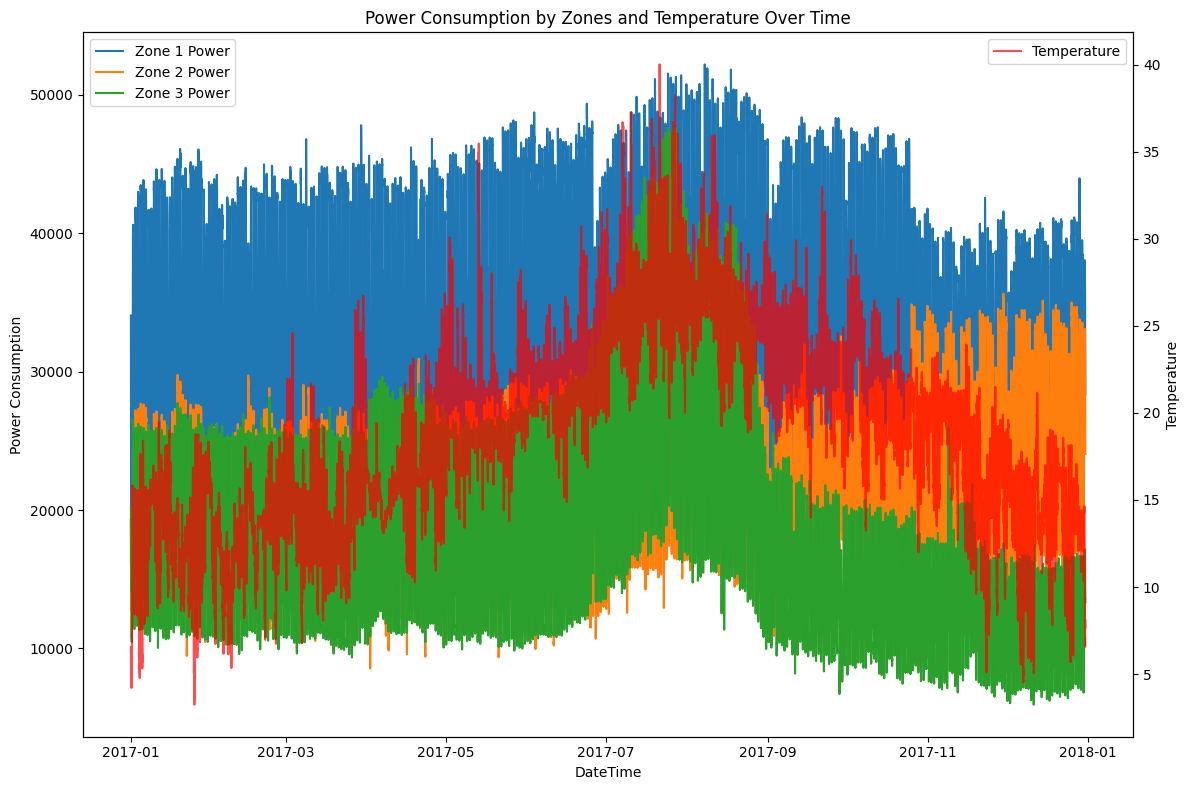

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plotear las variables
ax.plot(df_subset['datetime'], df_subset['zone_1'], label='Zone 1 Power', linewidth=1.5)
ax.plot(df_subset['datetime'], df_subset['zone_2'], label='Zone 2 Power', linewidth=1.5)
ax.plot(df_subset['datetime'], df_subset['zone_3'], label='Zone 3 Power', linewidth=1.5)

# Crear segundo eje Y para temperatura (escala diferente)
ax2 = ax.twinx()
ax2.plot(df_subset['datetime'], df_subset['temperature'], label='Temperature',
         color='red', linewidth=1.5, alpha=0.7)

# Configurar etiquetas y t√≠tulo
ax.set_xlabel('DateTime')
ax.set_ylabel('Power Consumption')
ax2.set_ylabel('Temperature')
ax.set_title('Power Consumption by Zones and Temperature Over Time')

# Configurar leyendas
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotar fechas para mejor legibilidad
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [4]:
# Mostrar informaci√≥n del subset
print("Informaci√≥n del dataset:")
print(df_subset.info())

Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     52416 non-null  datetime64[ns]
 1   zone_1       52416 non-null  float64       
 2   zone_2       52416 non-null  float64       
 3   zone_3       52416 non-null  float64       
 4   temperature  52416 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB
None


In [5]:
variables = ["temperature", "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]
df_zone1 = df[["zone_1"] + variables].copy()

Extracci√≥n de caracter√≠sticas (como la estacionariedad).

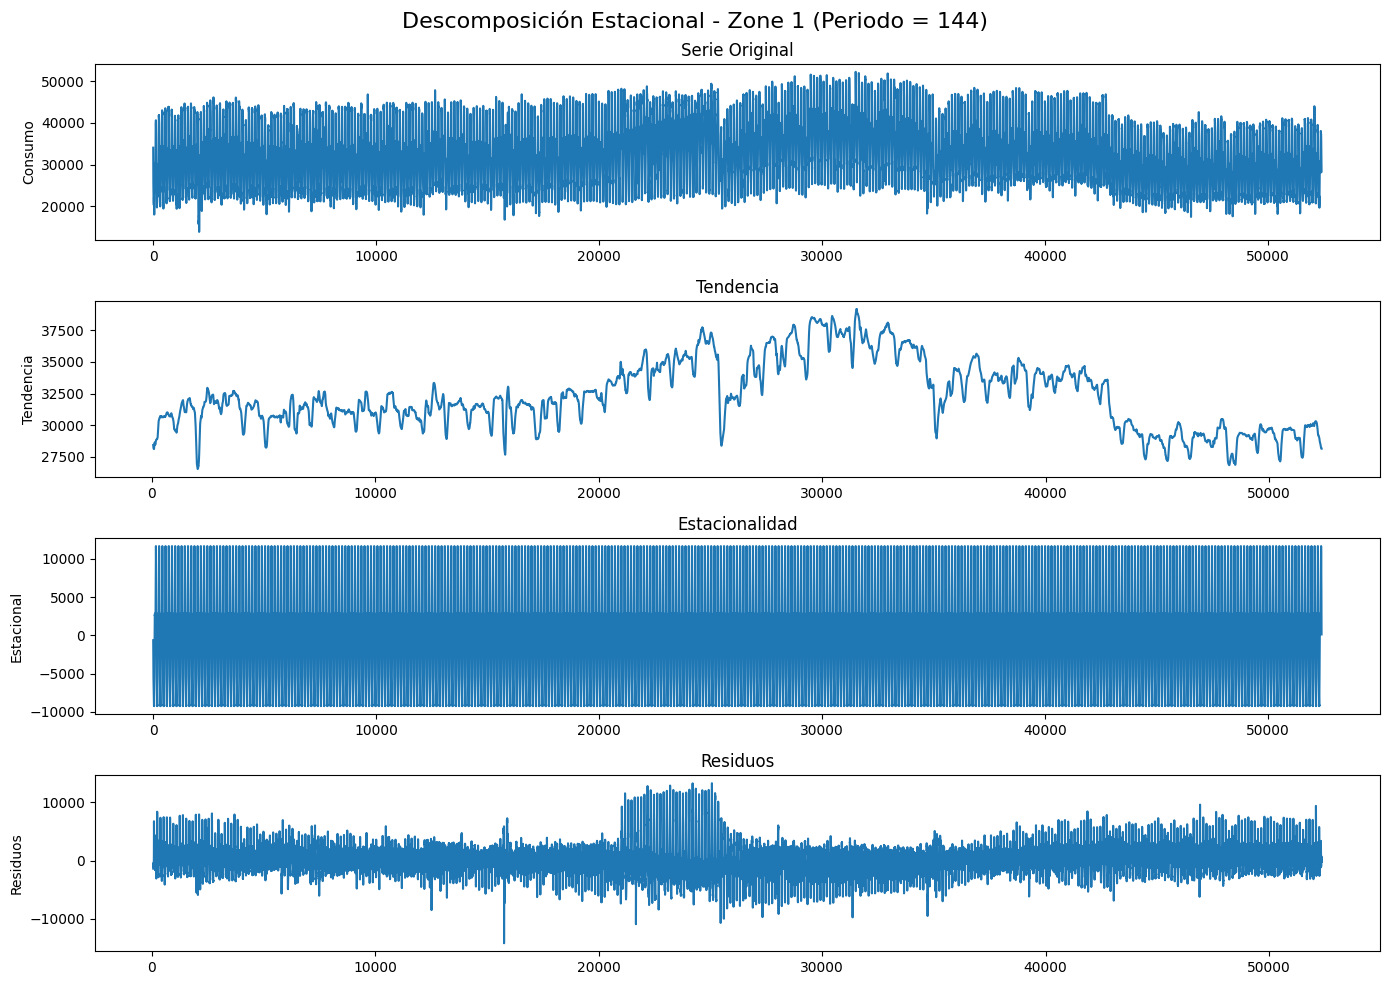

In [6]:
serie = df_zone1['zone_1']
decomposition = seasonal_decompose(serie, model='additive', period=144)

# Visualizar descomposici√≥n
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

serie.plot(ax=axes[0], title='Serie Original')
axes[0].set_ylabel('Consumo')

decomposition.trend.plot(ax=axes[1], title='Tendencia')
axes[1].set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
axes[2].set_ylabel('Estacional')

decomposition.resid.plot(ax=axes[3], title='Residuos')
axes[3].set_ylabel('Residuos')

plt.suptitle('Descomposici√≥n Estacional - Zone 1 (Periodo = 144)', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
print("\n=== Test de Dickey-Fuller Aumentado (Serie Original) ===")
result_adf = adfuller(serie.dropna())
print(f'ADF Statistic: {result_adf[0]:.4f}')
print(f'p-value: {result_adf[1]:.10f}')
print('Valores cr√≠ticos:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value:.3f}')


=== Test de Dickey-Fuller Aumentado (Serie Original) ===
ADF Statistic: -32.1213
p-value: 0.0000000000
Valores cr√≠ticos:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Analisis sobre la selecci√≥n de hiperpar√°metros.

Inicialmente, se tiene que el test de Dickey-Fuller arroj√≥ un p-valor = 0.000, por lo que la serie es estacionaria y no se debe diferenciar, d = 0. La componente p de n√∫mero de t√©rminos autorregresivos se puede encontrar a partir de la gr√°fica de autocorrelaci√≥n parcial. Se pueden ver picos m√°s significativos en el lag 1 y 2, seguido de un corte abrupto. Esto indica un p = 1 o 2. La ACF no presenta un corte abrupto sino un decaimiento oscilatorio que cruza r√°pidamente las bandas de confianza, sugiriendo que q=0, aunque podr√≠a considerarse q=1 para capturar peque√±os efectos de media m√≥vil.

---

#### **Predicci√≥n**

### MODELO ARIMA

In [9]:
def smape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  return np.mean(np.abs(y_true - y_pred) / denominator) * 100

def wape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

A un paso

In [10]:
# Usar √∫ltimos 90 d√≠as
n_dias = 90
n_observaciones = n_dias * 24 * 6  # 90 d√≠as * 24h * 6 intervalos = 12960 observaciones

In [11]:
# PREDICCI√ìN A UN PASO (10 minutos adelante)

# Seleccionar datos recientes
serie_reciente = serie.tail(n_observaciones)
variable_exogena = df_zone1['temperature'].tail(n_observaciones)

# Divisi√≥n train/test (80/20)
split_point = int(len(serie_reciente) * 0.8)
train_serie = serie_reciente[:split_point]
test_serie = serie_reciente[split_point:]
train_exog = variable_exogena[:split_point]
test_exog = variable_exogena[split_point:]

print("=== CONFIGURACI√ìN PARA PREDICCI√ìN A UN PASO (10 minutos) ===")
print(f"Total observaciones: {len(serie_reciente)}")
print(f"Train: {len(train_serie)} observaciones ({len(train_serie)/6:.1f} horas)")
print(f"Test: {len(test_serie)} observaciones ({len(test_serie)/6:.1f} horas)")
print(f"Horizonte de predicci√≥n: 1 paso (10 minutos)")


=== CONFIGURACI√ìN PARA PREDICCI√ìN A UN PASO (10 minutos) ===
Total observaciones: 12960
Train: 10368 observaciones (1728.0 horas)
Test: 2592 observaciones (432.0 horas)
Horizonte de predicci√≥n: 1 paso (10 minutos)


In [12]:
print("=== MODELO ARIMA - PREDICCI√ìN A UN PASO ===")

# Par√°metros ARIMA basados en an√°lisis previo
p, d, q = 2, 0, 0

# Ajustar modelo ARIMA
print(f"Ajustando ARIMA({p},{d},{q})...")
import time
start_time = time.time()

try:
    modelo_arima = ARIMA(train_serie, order=(p, d, q))
    resultado_arima = modelo_arima.fit()

    train_time_arima = time.time() - start_time
    print(f"Tiempo de entrenamiento: {train_time_arima:.2f} segundos")

    # Predicciones a un paso
    start_time = time.time()
    pred_arima = resultado_arima.forecast(steps=len(test_serie))
    pred_time_arima = time.time() - start_time

    # M√©tricas ARIMA
    smape_arima = smape(test_serie, pred_arima)
    wape_arima = wape(test_serie, pred_arima)

    print(f"\nM√©tricas ARIMA:")
    print(f"sMAPE: {smape_arima:.2f}%")
    print(f"WAPE: {wape_arima:.2f}%")
    print(f"AIC: {resultado_arima.aic:.2f}")
    print(f"BIC: {resultado_arima.bic:.2f}")
    print(f"Tiempo de predicci√≥n: {pred_time_arima:.2f} segundos")

except Exception as e:
    print(f"Error en ARIMA: {e}")
    pred_arima = None

=== MODELO ARIMA - PREDICCI√ìN A UN PASO ===
Ajustando ARIMA(2,0,0)...
Tiempo de entrenamiento: 1.31 segundos

M√©tricas ARIMA:
sMAPE: 18.32%
WAPE: 18.16%
AIC: 154173.44
BIC: 154202.42
Tiempo de predicci√≥n: 0.07 segundos


A m√∫ltiples pasos

In [13]:
# PREDICCI√ìN A M√öLTIPLES PASOS
# Predecir las pr√≥ximas 3 horas (18 observaciones)

print("\n=== CONFIGURACI√ìN PARA PREDICCI√ìN A M√öLTIPLES PASOS (3 horas) ===")

# Usar los mismos datos pero ahora predecir m√∫ltiples pasos
n_pasos_futuro = 18  # 3 horas = 18 intervalos de 10 minutos

# Para m√∫ltiples pasos, necesitamos un conjunto de test m√°s peque√±o
# para poder comparar las predicciones
test_multi_input = test_serie[:-n_pasos_futuro]  # Datos para hacer la predicci√≥n
test_multi_real = test_serie[-n_pasos_futuro:]   # Valores reales a comparar

test_exog_multi = test_exog[:-n_pasos_futuro]
test_exog_real = test_exog[-n_pasos_futuro:]

print(f"Horizonte de predicci√≥n: {n_pasos_futuro} pasos ({n_pasos_futuro*10} minutos = {n_pasos_futuro/6:.1f} horas)")
print(f"Puntos para evaluar: {len(test_multi_real)}")


=== CONFIGURACI√ìN PARA PREDICCI√ìN A M√öLTIPLES PASOS (3 horas) ===
Horizonte de predicci√≥n: 18 pasos (180 minutos = 3.0 horas)
Puntos para evaluar: 18


In [14]:
print("=== MODELO ARIMA - PREDICCI√ìN A M√öLTIPLES PASOS (3 horas) ===")

start_time = time.time()

try:
    # Reajustar el modelo con todos los datos hasta el punto de predicci√≥n
    train_multi = pd.concat([train_serie, test_multi_input])
    modelo_arima_multi = ARIMA(train_multi, order=(p, d, q))
    resultado_arima_multi = modelo_arima_multi.fit()

    train_time_arima_multi = time.time() - start_time

    # Predicci√≥n m√∫ltiples pasos
    start_time = time.time()
    pred_arima_multi = resultado_arima_multi.forecast(steps=n_pasos_futuro)
    pred_time_arima_multi = time.time() - start_time


    # M√©tricas ARIMA
    smape_arima_multi = smape(test_multi_real, pred_arima_multi)
    wape_arima_multi = wape(test_multi_real, pred_arima_multi)

    print(f"Tiempo de entrenamiento: {train_time_arima_multi:.2f} segundos")
    print(f"\nM√©tricas ARIMA (3 horas adelante):")
    print(f"\nM√©tricas ARIMA:")
    print(f"sMAPE: {smape_arima_multi:.2f}%")
    print(f"WAPE: {wape_arima_multi:.2f}%")
    print(f"AIC: {resultado_arima_multi.aic:.2f}")
    print(f"BIC: {resultado_arima_multi.bic:.2f}")
    print(f"Tiempo de predicci√≥n: {pred_time_arima_multi:.2f} segundos")

except Exception as e:
    print(f"Error en ARIMA m√∫ltiples pasos: {e}")
    pred_arima_multi = None

=== MODELO ARIMA - PREDICCI√ìN A M√öLTIPLES PASOS (3 horas) ===
Tiempo de entrenamiento: 0.75 segundos

M√©tricas ARIMA (3 horas adelante):

M√©tricas ARIMA:
sMAPE: 6.14%
WAPE: 6.07%
AIC: 191667.43
BIC: 191697.30
Tiempo de predicci√≥n: 0.03 segundos


---

### MODELO SARIMAX

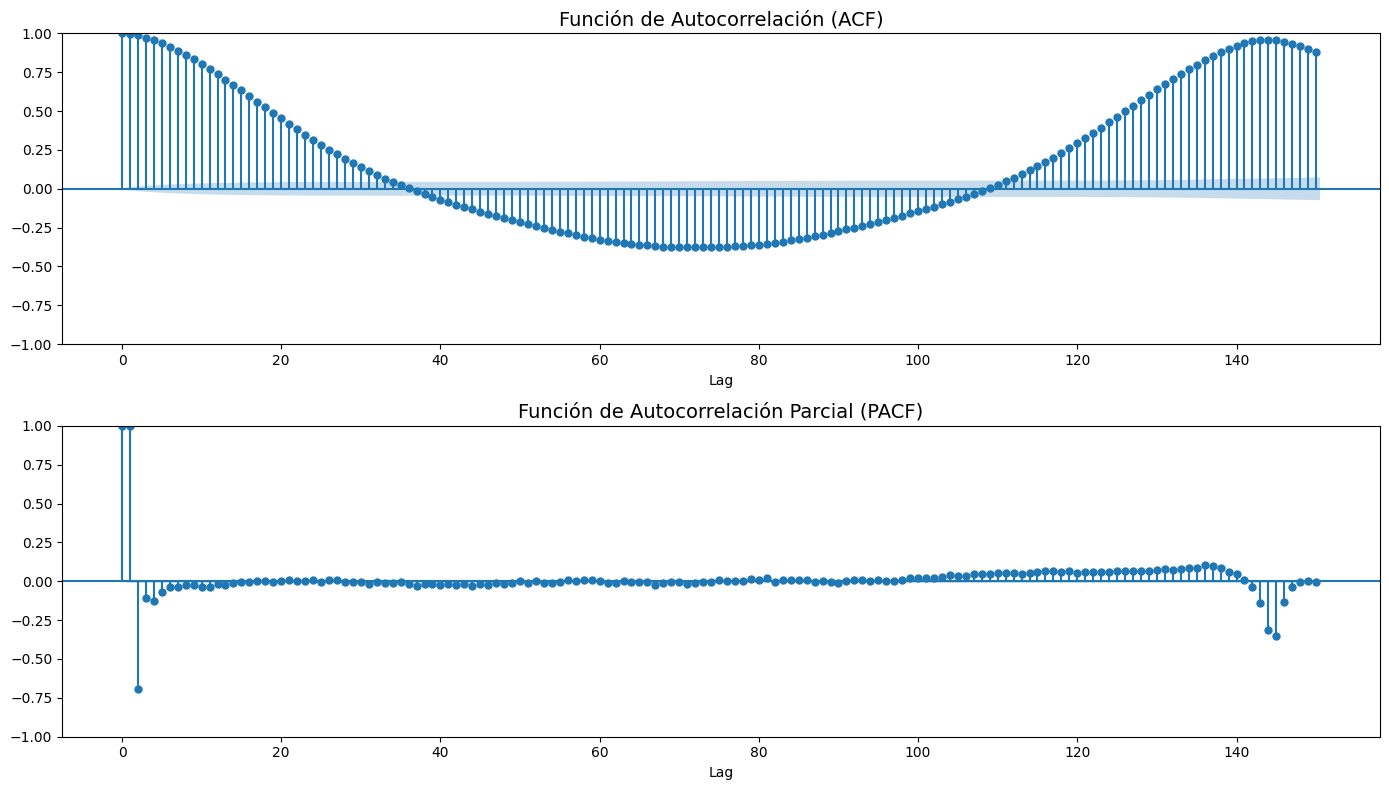

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(serie.dropna(), lags=150, ax=ax1)
ax1.set_title('Funci√≥n de Autocorrelaci√≥n (ACF)', fontsize=14)
ax1.set_xlabel('Lag')

# PACF
plot_pacf(serie.dropna(), lags=150, ax=ax2)
ax2.set_title('Funci√≥n de Autocorrelaci√≥n Parcial (PACF)', fontsize=14)
ax2.set_xlabel('Lag')

plt.tight_layout()
plt.show()


La serie temporal presenta una estacionalidad diaria extremadamente marcada, evidenciada por el comportamiento casi sinusoidal de la ACF con un pico dominante cerca del lag 144 (equivalente a 24 horas con mediciones cada 10 minutos), sugiriendo la presencia de una ra√≠z unitaria estacional que requiere diferenciaci√≥n estacional (D=1). La PACF revela un spike significativo en los lags iniciales y m√∫ltiples picos negativos alrededor del lag 144, patr√≥n caracter√≠stico que indica que, tras aplicar la diferenciaci√≥n estacional, un t√©rmino de media m√≥vil estacional captura eficientemente la dependencia temporal, siendo Q=1 la mejor elecci√≥n. Considerando que el modelo base ya incorpora order=(2,0,0), la configuraci√≥n estacional √≥ptima ser√≠a seasonal_order=(0,1,1,144) como punto de partida, dado que es la parametrizaci√≥n m√°s habitual cuando la ACF estacional domina el comportamiento de la serie.

In [16]:
# Par√°metros SARIMAX con estacionalidad diaria
order = (2, 0, 0)
seasonal_order = (0, 1, 1, 144)  # 144 = 24 horas * 6 intervalos

In [ ]:
print(f"\n=== MODELO SARIMAX (con temperatura) - PREDICCI√ìN A UN PASO ===")

start_time = time.time()

try:
    # Entrenamiento
    modelo_sarimax = SARIMAX(
        train_serie,
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado_sarimax = modelo_sarimax.fit(disp=False)

    train_time_sarimax = time.time() - start_time
    print(f"Tiempo de entrenamiento: {train_time_sarimax:.2f} segundos")

    # --- Predicci√≥n a un paso ---
    start_time = time.time()
    # Solo el siguiente valor despu√©s del train
    pred_sarimax = resultado_sarimax.get_forecast(
        steps=1,
        exog=test_exog.iloc[[0]]  # solo la 1ra fila de ex√≥gena de test
    ).predicted_mean
    pred_time_sarimax = time.time() - start_time

    # M√©tricas SARIMAX (comparando solo con el primer valor de test)
    smape_sarimax = smape(test_serie.iloc[0], pred_sarimax)
    wape_sarimax  = wape(test_serie.iloc[0], pred_sarimax)

    print(f"\nM√©tricas SARIMAX (un paso):")
    print(f"sMAPE: {smape_sarimax:.2f}%")
    print(f"WAPE : {wape_sarimax:.2f}%")
    print(f"AIC: {resultado_sarimax.aic:.2f}")
    print(f"BIC: {resultado_sarimax.bic:.2f}")
    print(f"Tiempo de predicci√≥n: {pred_time_sarimax:.2f} segundos")

except Exception as e:
    print(f"Error en SARIMAX un paso: {e}")
    pred_sarimax = None



=== MODELO SARIMAX (con temperatura) - PREDICCI√ìN A UN PASO ===


In [ ]:
print("\n=== PREDICCI√ìN SARIMAX - MULTI-STEP (3h adelante) ===")


try:
    pred_sarimax_multi = resultado_sarimax.forecast(
        steps=n_pasos_futuro,
        exog=test_exog_real
    )

    smape_sarimax_multi = smape(test_multi_real, pred_sarimax_multi)
    wape_sarimax_multi  = wape(test_multi_real, pred_sarimax_multi)

    print(f"sMAPE: {smape_sarimax_multi:.2f}%")
    print(f"WAPE : {wape_sarimax_multi:.2f}%")
    print(f"AIC: {resultado_sarimax.aic:.2f}")
    print(f"BIC: {resultado_sarimax.bic:.2f}")

except Exception as e:
    print(f"Error en SARIMAX m√∫ltiples pasos: {e}")
    pred_sarimax_multi = None

#### **Analisis de resultados**

### PRON√ìSTICO A UN PASO MODELOS ARIMA Y SARIMAX

In [ ]:
plt.figure(figsize=(14,6))

# Serie real de test
plt.plot(test_serie.index, test_serie, label="Test Real", color="black", linewidth=2)

# Predicci√≥n ARIMA
if pred_arima is not None:
    plt.plot(test_serie.index, pred_arima, label="ARIMA (1 paso)", color="blue", linestyle="--", alpha=0.8)

# Predicci√≥n SARIMAX
if pred_sarimax is not None:
    plt.plot(test_serie.index, pred_sarimax, label="SARIMAX (1 paso)", color="red", linestyle="--", alpha=0.8)

plt.title("Predicci√≥n a 1 Paso Adelante (Test vs ARIMA vs SARIMAX)", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a (Zone 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

TODO: an√°lisis de la gr√°fica

### PRON√ìSTICO A M√öLTIPLES PASOS MODELOS ARIMA Y SARIMAX

In [ ]:
plt.figure(figsize=(14,6))

# Valores reales de las √∫ltimas 3 horas
plt.plot(test_multi_real.index, test_multi_real, label="Test Real (3h)", color="black", linewidth=2)

# Predicci√≥n ARIMA multi-step
if pred_arima_multi is not None:
    plt.plot(test_multi_real.index, pred_arima_multi, label="ARIMA (3h adelante)", color="blue", linestyle="--", alpha=0.8)

# Predicci√≥n SARIMAX multi-step
if pred_sarimax_multi is not None:
    plt.plot(test_multi_real.index, pred_sarimax_multi, label="SARIMAX (3h adelante)", color="red", linestyle="--", alpha=0.8)

plt.title("Predicci√≥n M√∫ltiples Pasos (3h adelante) - ARIMA vs SARIMAX", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a (Zone 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

TODO: An√°lisis de la gr√°fica

M√©tricas a evaluar:
1. sMAPE
2. WAPE

In [ ]:
# ================================
# TABLA 1: Pron√≥stico a 1 paso
# ================================
resultados_1paso = []

# ARIMA (1 paso)
if pred_arima is not None:
    resultados_1paso.append({
        "Modelo": "ARIMA",
        "Horizonte": "1 paso",
        "sMAPE (%)": round(smape_arima, 2),
        "WAPE (%)": round(wape_arima, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX (1 paso)
if pred_sarimax is not None:
    resultados_1paso.append({
        "Modelo": "SARIMAX",
        "Horizonte": "1 paso",
        "sMAPE (%)": round(smape_sarimax, 2),
        "WAPE (%)": round(wape_sarimax, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })

df_resultados_1paso = pd.DataFrame(resultados_1paso)
print("\nüìä Resultados Pron√≥stico a 1 Paso:")
print(df_resultados_1paso)


# ================================
# TABLA 2: Pron√≥stico multi-step
# ================================
resultados_multi = []

# ARIMA (multi-step)
if pred_arima_multi is not None:
    resultados_multi.append({
        "Modelo": "ARIMA",
        "Horizonte": "3h adelante",
        "sMAPE (%)": round(smape_arima_multi, 2),
        "WAPE (%)": round(wape_arima_multi, 2),
        "AIC": round(resultado_arima_multi.aic, 2),
        "BIC": round(resultado_arima_multi.bic, 2)
    })

# SARIMAX (multi-step)
if pred_sarimax_multi is not None:
    resultados_multi.append({
        "Modelo": "SARIMAX",
        "Horizonte": "3h adelante",
        "sMAPE (%)": round(smape_sarimax_multi, 2),
        "WAPE (%)": round(wape_sarimax_multi, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })

df_resultados_multi = pd.DataFrame(resultados_multi)
print("\nüìä Resultados Pron√≥stico Multi-Step (3h):")
print(df_resultados_multi)

---

TODO: An√°lisis de las m√©tricas

### REFERENCIAS:

Gianpiero Andrenacci. (2024, September 3). Predicting Time-Series with SARIMAX. Medium; AI Bistrot. https://medium.com/data-bistrot/predicting-time-series-with-sarimax-f805f6608cd2

‚Äågianpieroandrenacci. (2024, July 13). üìà COVID-19 New Cases in Italy prediction (ARIMA). Kaggle.com; Kaggle. https://www.kaggle.com/code/gianpieroandrenacci/covid-19-new-cases-in-italy-prediction-arima?source=post_page-----f805f6608cd2---------------------------------------

‚Äå